In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import pandas as pd 
import numpy as np
import warnings
import torch

warnings.simplefilter(action='ignore', category=FutureWarning)

/homes/gws/mingyulu/miniconda3/envs/torch_gpu/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
Mask = torch.zeros((3,3))

cols = [2, -1, 0]
rows = [0,1,2]
Mask[rows, cols] = 1
Mask
feature_indices = [[1,2,5],
                     [7,3,4],
                     [2,4,5]]


print(feature_indices)

feature_indices = list(map(list, zip(*feature_indices)))
feature_indices

for i in feature_indices:
    print(i)

[[1, 2, 5], [7, 3, 4], [2, 4, 5]]
[1, 7, 2]
[2, 3, 4]
[5, 4, 5]


In [5]:
def plot_results(experiment, dataset, seeds):
    
    metrics = [
            "All features ACC",
            "All features ACC Score ",
            "Pred features ACC",
           "Pred features ACC Score ",
           "Prog features ACC",
           "Prog features ACC Score ",
           "PEHE"]

    explainers = [#"feature_ablation",
                 #"feature_permutation",
                 "integrated_gradients",
                 "shapley_value_sampling",
                 "naive_shap",
                 "explain_with_missingness"]
    
    models = ["DRLearner", "XLearner"]
    
    plt.figure(figsize=(15,12))

    for model_index , model in enumerate(models):

        datasets_list = []

        for seed in seeds:
            
            linear_path = "predictive_sensitivity/sample/predictive_scale_"+ \
                        dataset+\
                        "_linear_random_True_binary_False_"+\
                          seed+".csv"
            linear_mask_path = "predictive_sensitivity_mask/sample/predictive_scale_"+ \
                        dataset+\
                        "_linear_random_True_binary_False_"+\
                          seed+".csv"
                        
            nonlinear_path = "nonlinearity_sensitivity/sample/random/"+\
                            dataset+ "_binary_False_"+seed+".csv"
            nonlinear_mask_path = "nonlinearity_sensitivity_mask/sample/random/"+\
                            dataset+ "_binary_False_"+seed+".csv"
            
            if experiment == "Predictive Scale":

                data = pd.read_csv(linear_path, index_col = 0)
                datasets_list.append(data[data.Learner == model]) 
                data = pd.read_csv(linear_mask_path,index_col=0)
                datasets_list.append(data[data.Learner == (model+"Mask")])

            elif experiment == "Nonlinearity Scale":

                data = pd.read_csv(nonlinear_path,index_col = 0)
                datasets_list.append(data[data.Learner == model]) 
                data = pd.read_csv(nonlinear_mask_path, index_col=0)
                datasets_list.append(data[data.Learner == (model+"Mask")])

        datasets = pd.concat(datasets_list, ignore_index=True)    

        for metric_index, metric in enumerate(metrics):

            plt.subplot(4, len(metrics), len(metrics)*model_index+metric_index+1)

            for e in explainers:

                data = datasets[datasets.Explainer == e]

                mean = data.groupby(experiment).mean().reset_index()
                std = data.groupby(experiment).std().reset_index()
                std = std/np.sqrt(len(seeds))

                if e == "shapley_value_sampling":
                    e = "Shapley value - replacing with 0"
                elif e == "naive_shap":
                    e = "Shapley value - marginal distribution"
                elif e == "integrated_gradients":
                    e = "Integrated Gradients"
                elif e == "explain_with_missingness":
                    e = "Shapley value - training with missingness"

                plt.plot(mean[experiment], mean[metric], label=e)
                plt.fill_between(mean[experiment], 
                                 np.where(mean[metric]-std[metric]>0, mean[metric]-std[metric],0),
                                 mean[metric]+std[metric],  
                                 alpha=.05)

            plt.xlabel(experiment)
            plt.ylabel(metric)
            plt.title(metric)

    if dataset == "acic_10":
        plt.suptitle("ACIC - " + experiment + " - "+ str([i for i in models]) + "\n" + \
                     r'20 predictive features, (10 pred$_0$ + 10 pred$_1$), and 10 prognostic features out of 55 features'
                     , fontsize=14)
    elif dataset == "twins_8":
        plt.suptitle("Twins - " + experiment + " - "+  str([i for i in models]) + "\n" + \
                     r'16 predictive features, (8 pred$_0$ + 8 pred$_1$), and 8 prognostic features out of 39 features' 
                     , fontsize=14)
    elif dataset == "tcga_100_20":
        plt.suptitle("TCGA - "+  experiment + " - "+  str([i for i in models]) + "\n" + \
                     r'40 predictive features, (20 pred$_0$ + 20 pred$_1$), and 20 prognostic features out of 100 features'
                     , fontsize=14)
    elif dataset == "news_100_20":
        plt.suptitle("News - "+  experiment + " - "+  str([i for i in models]) + "\n" + \
                     r'40 predictive features, (20 pred$_0$ + 20 pred$_1$), and 20 prognostic features out of 100 features'
                     , fontsize=14)
        
    plt.tight_layout()
    plt.legend(bbox_to_anchor=(1.0, -0.4),ncol=len(explainers),prop={'size': 12})

## TWINS - 8 important features out of 39

##### The Twins dataset [50] consists of information from 11400 twin births in the USA recordedbetween 1989-1991. 
##### Each twin pair is characterized by39 covariates related to the parents, pregnancy and birth; these represent a mixture of continuous and categorical features.
##### In our experiments, the publicly available version of the dataset from Catenets is used where we randomly sample one ofthe twins to observe

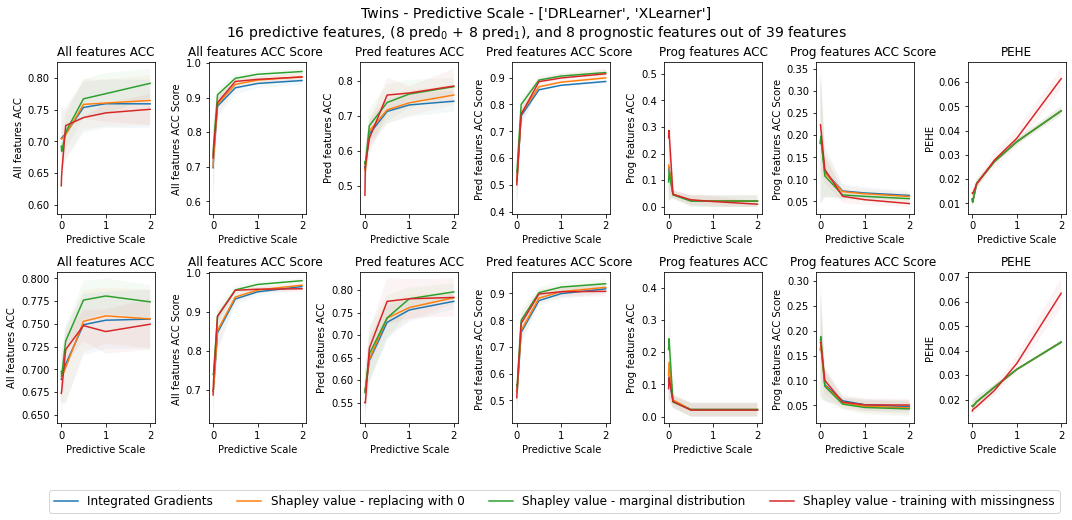

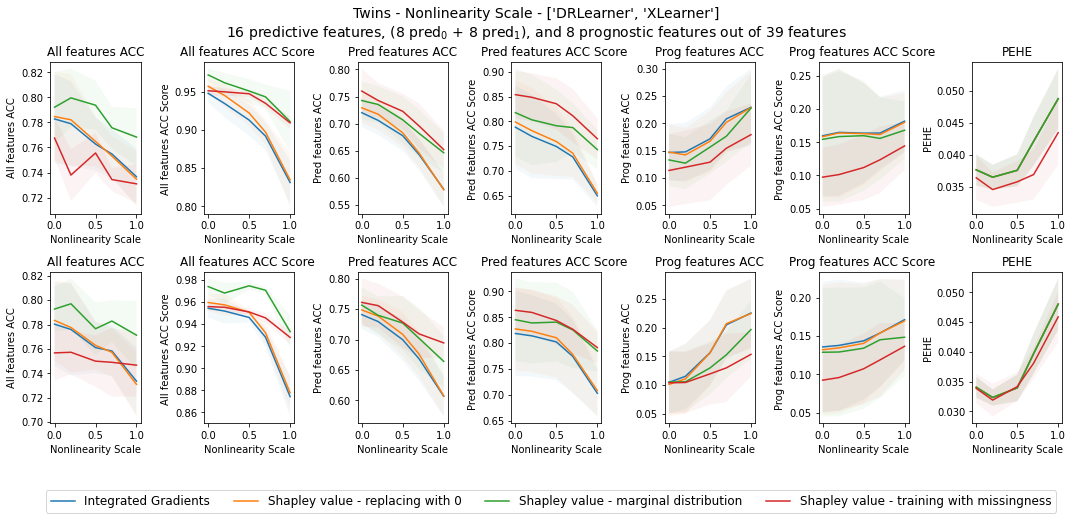

In [9]:
plot_results("Predictive Scale", "twins_8"
                ,seeds = [ #"seed1",
                           #"seed2",
                           "seed3",
                           "seed4",
                           "seed5",
                        ])

plot_results("Nonlinearity Scale",
                "twins_8",
                seeds = [
                          #"seed1",
                          "seed2",
                          "seed3",
                          "seed4",
                          "seed5",
                        ])

## ACIC 

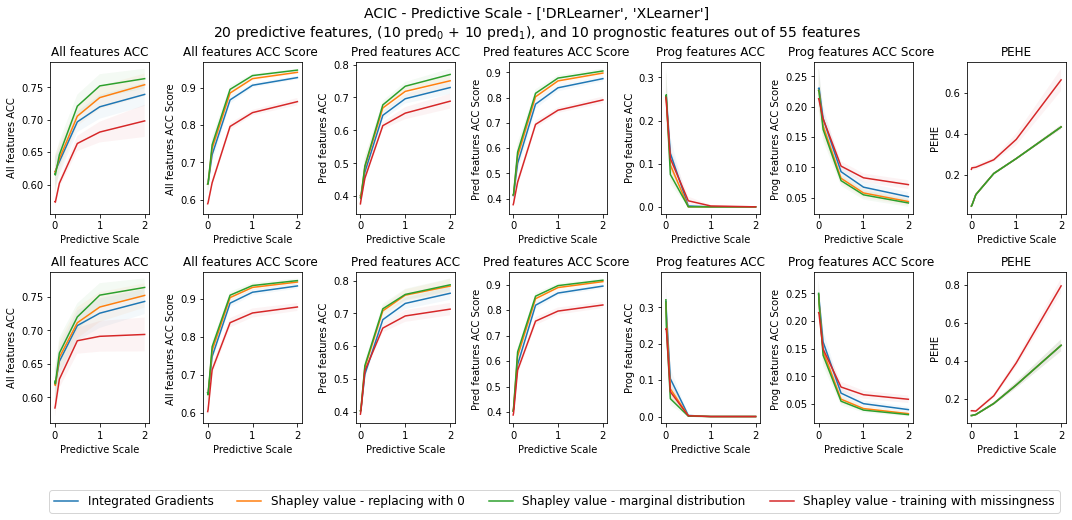

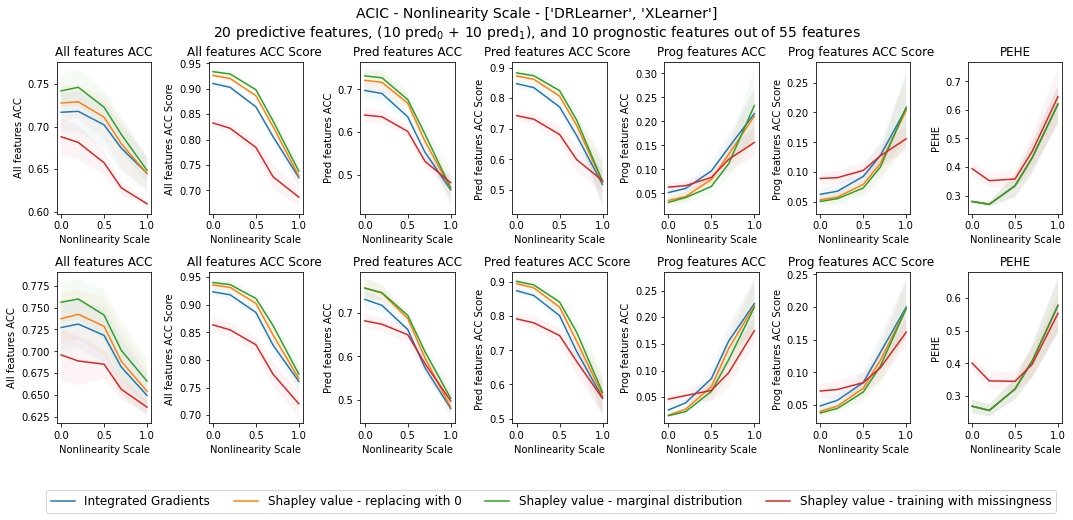

In [10]:
plot_results("Predictive Scale", "acic_10"
                ,seeds = ["seed1",
                         "seed2",
                         "seed3",
                         "seed4",
                         "seed5",
                        ])

plot_results("Nonlinearity Scale",
                "acic_10",
                seeds = [
                         "seed1",
                         #"seed2",
                         "seed3",
                         "seed4",
                         "seed5",
                        ])

## TCGA

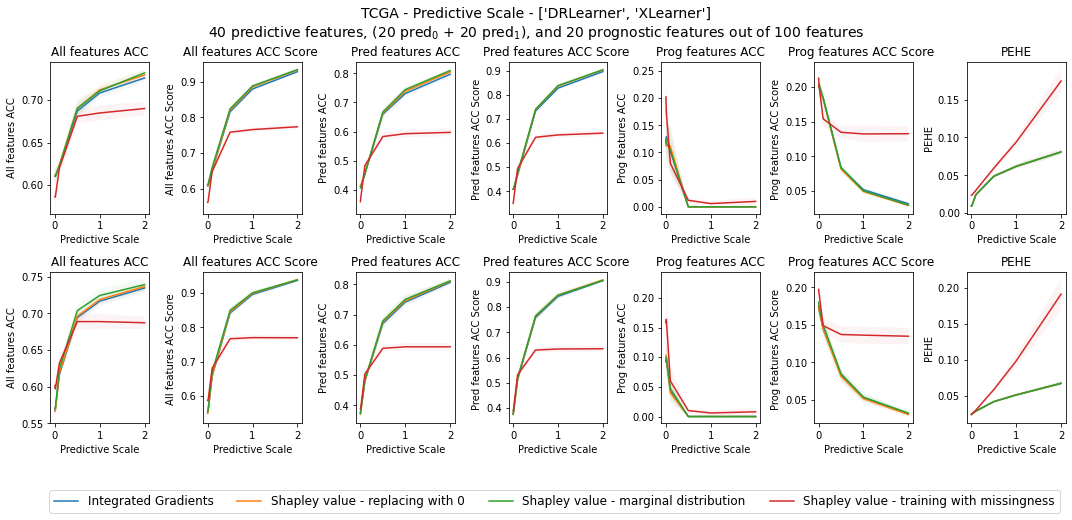

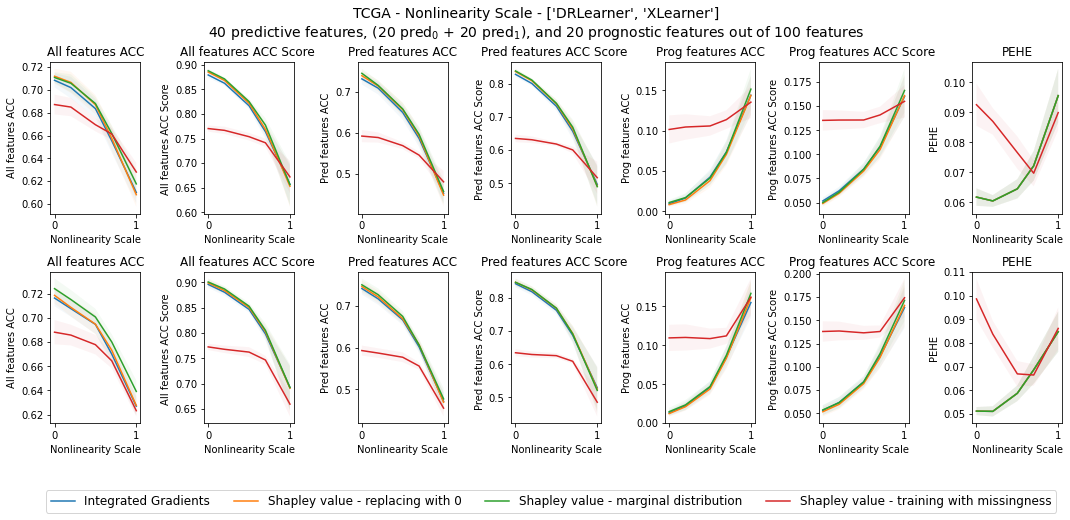

In [11]:
plot_results("Predictive Scale",
              "tcga_100_20"
                ,seeds = ["seed1",
                         "seed2",
                         "seed3",
                         "seed4",
                         "seed5",
                        ])

plot_results("Nonlinearity Scale",
              "tcga_100_20",
                seeds = [
                         "seed1",
                         "seed2",
                         "seed3",
                         "seed4",
                         "seed5",
                        ])

## News

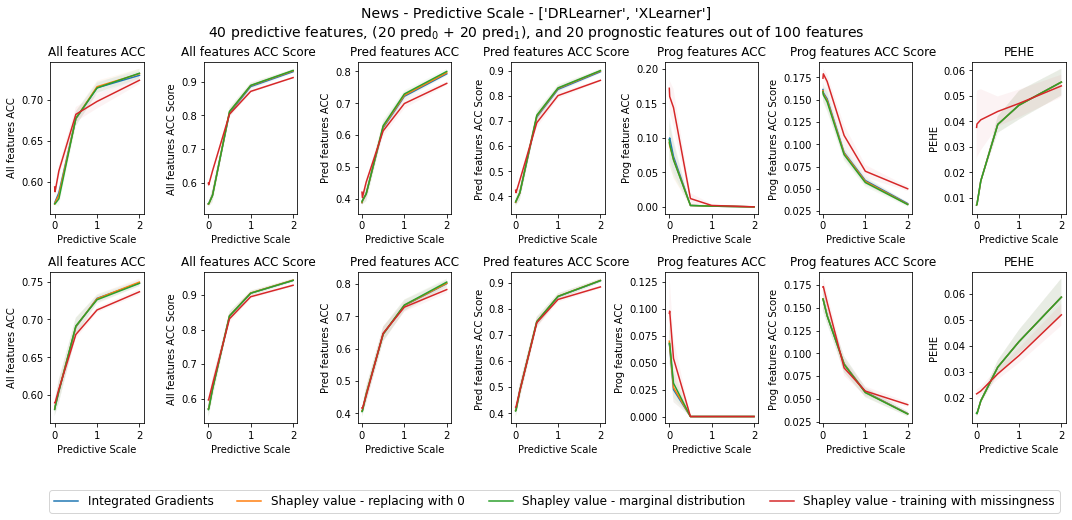

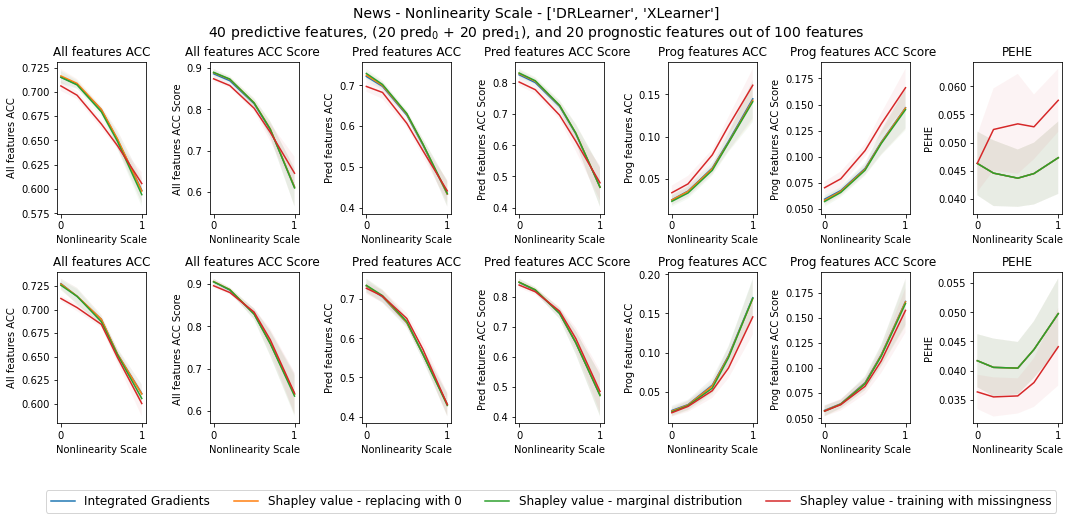

In [12]:
plot_results("Predictive Scale", 
             "news_100_20"
                ,seeds = [
                          "seed1",
                          "seed2",
                          "seed3",
                          "seed4",
                         "seed5",
                        ])

plot_results("Nonlinearity Scale",
                "news_100_20",
                seeds = [
                         "seed1",
                         "seed2",
                         "seed3",
                         "seed4",
                         "seed5",
                        ])

In [ ]:
plot_results("Propensity Scale", 
             "news_100_20"
                ,seeds = [
                          "seed1",
                          "seed2",
                          "seed3",
                          "seed4",
                         "seed5",
                        ])

plot_results("Propensity Scale",
                "news_100_20",
                seeds = [
                         "seed1",
                         "seed2",
                         "seed3",
                         "seed4",
                         "seed5",
                        ])

### Propensity == Pred

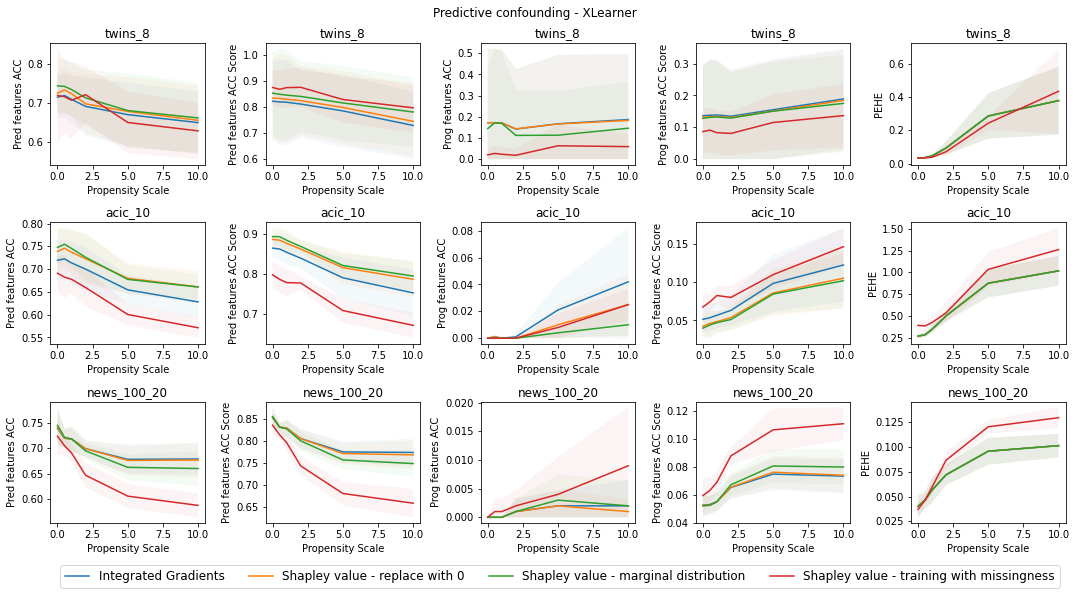

In [856]:
dataset_list = [
                   "twins_8",
                   "acic_10",
                   #"tcga_100_20",
                    "news_100_20"
                   ]

metrics = ["Pred features ACC",
           "Pred features ACC Score",
           "Prog features ACC",
           "Prog features ACC Score",
           "PEHE"]

seeds = ["seed1",
         "seed2",
         "seed3",
         "seed4",
         "seed5"
        ]

explainers = [#"feature_ablation",
             #"feature_permutation",
             "integrated_gradients",
             "shapley_value_sampling",
             "naive_shap",
             "explain_with_missingness"]

experiment_name = "Propensity Scale"
propensity_type = "pred"

plt.figure(figsize=(15,10))



for data_index in range(len(dataset_list)):
    datasets_list = []
    
    for seed_index, seed in enumerate(seeds):
        
        data = pd.read_csv("propensity_sensitivity/sample/linear/"+
                           propensity_type +
                           "/propensity_scale_"+
                           dataset_list[data_index]+
                           "_proptype_"+
                           propensity_type+
                           "_predscl_1.0_nonlinscl_0.5_trainratio_0.8_binary_False-"
                           +seed+".csv",
                           index_col=0)
        
        
        data = data[data.Learner == "XLearner"]
        datasets_list.append(data) 
        
        data = pd.read_csv("propensity_sensitivity_mask/sample/linear/"+
                           propensity_type +
                           "/propensity_scale_"+
                           dataset_list[data_index]+
                           "_proptype_"+
                           propensity_type+
                           "_predscl_1.0_nonlinscl_0.5_trainratio_0.8_binary_False-"
                           +seed+".csv",
                           index_col=0)
        
        datasets_list.append(data[data.Learner == "XLearnerMask"])
        
    datasets = pd.concat(datasets_list, ignore_index=True)    
    
    for metric_index in range(len(metrics)):
        metric = metrics[metric_index]

        plt.subplot(4, len(metrics), len(metrics)*data_index+metric_index+1)

        for e in explainers:

            data = datasets[datasets.Explainer == e]
            
            if e == "shapley_value_sampling":
                e = "Shapley value - replace with 0"
            elif e == "naive_shap":
                e = "Shapley value - marginal distribution"
            elif e == "integrated_gradients":
                e = "Integrated Gradients"
            elif e == "explain_with_missingness":
                e = "Shapley value - training with missingness"
                
            mean = data.groupby(experiment_name).mean().reset_index()
            std = data.groupby(experiment_name).std().reset_index()

            plt.plot(mean[experiment_name], mean[metric], label=e)
            plt.fill_between(mean[experiment_name], np.where(mean[metric]-std[metric]>0, mean[metric]-std[metric],0), mean[metric]+std[metric],  alpha=.05)

        plt.xlabel(experiment_name)
        plt.ylabel(metric)
        plt.title(dataset_list[data_index])
        
plt.suptitle("Predictive confounding - XLearner " )
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.0, -0.3),ncol=len(explainers),prop={'size': 12})

### Propensity - prog

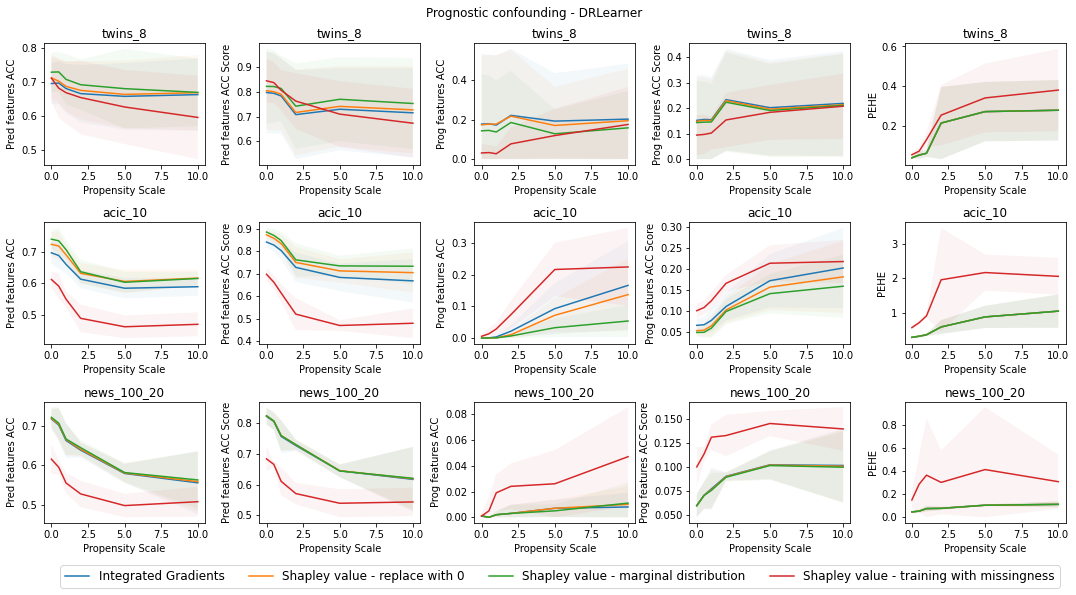

In [860]:
dataset_list = [
                   "twins_8",
                   "acic_10",
                   #"tcga_100_20",
                    "news_100_20"
                   ]

metrics = ["Pred features ACC",
           "Pred features ACC Score",
           "Prog features ACC",
           "Prog features ACC Score",
           "PEHE"]

seeds = ["seed1",
         "seed2",
         "seed3",
         "seed4",
         "seed5"
        ]

explainers = [#"feature_ablation",
             #"feature_permutation",
             "integrated_gradients",
             "shapley_value_sampling",
             "naive_shap",
             "explain_with_missingness"]

experiment_name = "Propensity Scale"
propensity_type = "prog"

plt.figure(figsize=(15,10))



for data_index in range(len(dataset_list)):
    datasets_list = []
    
    for seed_index, seed in enumerate(seeds):
        
        data = pd.read_csv("propensity_sensitivity/sample/linear/"+
                           propensity_type +
                           "/propensity_scale_"+
                           dataset_list[data_index]+
                           "_proptype_"+
                           propensity_type+
                           "_predscl_1.0_nonlinscl_0.5_trainratio_0.8_binary_False-"
                           +seed+".csv",
                           index_col=0)
        
        
        data = data[data.Learner == "DRLearner"]
        datasets_list.append(data) 
        
        data = pd.read_csv("propensity_sensitivity_mask/sample/linear/"+
                           propensity_type +
                           "/propensity_scale_"+
                           dataset_list[data_index]+
                           "_proptype_"+
                           propensity_type+
                           "_predscl_1.0_nonlinscl_0.5_trainratio_0.8_binary_False-"
                           +seed+".csv",
                           index_col=0)
        
        datasets_list.append(data[data.Learner == "DRLearnerMask"])
        
    datasets = pd.concat(datasets_list, ignore_index=True)    
    
    for metric_index in range(len(metrics)):
        metric = metrics[metric_index]

        plt.subplot(4, len(metrics), len(metrics)*data_index+metric_index+1)

        for e in explainers:

            data = datasets[datasets.Explainer == e]
            
            if e == "shapley_value_sampling":
                e = "Shapley value - replace with 0"
            elif e == "naive_shap":
                e = "Shapley value - marginal distribution"
            elif e == "integrated_gradients":
                e = "Integrated Gradients"
            elif e == "explain_with_missingness":
                e = "Shapley value - training with missingness"
                
            mean = data.groupby(experiment_name).mean().reset_index()
            std = data.groupby(experiment_name).std().reset_index()

            plt.plot(mean[experiment_name], mean[metric], label=e)
            plt.fill_between(mean[experiment_name], np.where(mean[metric]-std[metric]>0, mean[metric]-std[metric],0), mean[metric]+std[metric],  alpha=.05)

        plt.xlabel(experiment_name)
        plt.ylabel(metric)
        plt.title(dataset_list[data_index])
        
plt.suptitle("Prognostic confounding - DRLearner " )
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.0, -0.3),ncol=len(explainers),prop={'size': 12})

In [ ]:
cblind_palete = sns.color_palette("colorblind", as_cmap=True)
learner_colors = {
    "SLearner": cblind_palete[0],
    "TLearner": cblind_palete[1],
    "XLearner": cblind_palete[2],
    "TARNet": cblind_palete[3],
    'CFRNet_0.01': cblind_palete[4],
    "CFRNet_0.001": cblind_palete[6],
    'CFRNet_0.0001': cblind_palete[9],
    "DRLearner": cblind_palete[7],
    "DRLearnerMask":  cblind_palete[7],
    "RALearner": cblind_palete[9],
    "Truth": cblind_palete[9],
}

learner_linestyles = {
    "SLearner": "-",
    "TLearner": "--",
    "XLearner": ":",
    "TARNet": "-.",
    "XLearner": "--",
    "CFRNet_0.01": "-",
    "CFRNet_0.001": ":",
    "CFRNet_0.0001": "--",
    "DRLearner": "-",
    "RALearner": "--",
    "Truth": ":",
    "DRLearnerMask": "-"

}


learner_markers = {
    "SLearner": "d",
    "TLearner": "o",
    "XLearner": "^",
    "TARNet": "*",
    "XLearner": "D",
    "CFRNet_0.01": "8",
    "CFRNet_0.001": "s",
    "CFRNet_0.0001": "x",
    "DRLearner": "x",
    "RALearner": "H",
    "Truth": "<",
    "DRLearnerMask": "x"
}

datasets_names_map = {
    "tcga_100": "TCGA", 
    "twins": "Twins", 
    "news_100": "News", 
    "acic": "ACIC2016", 
    "pred": "Predictive confounding", 
    "prog": "Prognostic confounding", 
    "irrelevant_var": "Non-confounded propensity"}

metric_names_map = {
    'Pred features ACC': r'$\mathrm{Attr}_{\mathrm{pred}}$',
    'Prog features ACC': r'$\mathrm{Attr}_{\mathrm{prog}}$',
    'PEHE': 'PEHE',
}

learners_names_map = {
    "TLearner":"T-Learner", 
    "SLearner": "S-Learner", 
    "TARNet": "TARNet",  
    "DRLearner": "DR-Learner", 
    "DRLearnerMask": "DRLearnerMask",
    "XLearner": "X-Learner", 
    "TARNet": "TARNet",
    "CFRNet_0.001": r'$\mathrm{CFRNet}(\gamma=0.001)$',  
    "CFRNet_0.01": r'$\mathrm{CFRNet}(\gamma=0.1)$', 
    "CFRNet_0.0001": r'$\mathrm{CFRNet}(\gamma=0.0001)$',
}


def plot_results_datasets(results_df_map, x_axis, x_label_name, x_values_to_plot, metrics_list, learners_list, figsize, legend_position, sharey=False, legend_rows=1): 
    font_size=20
    fig, axs = plt.subplots(len(metrics_list), len(results_df_map.keys()), figsize=figsize, squeeze=False, sharey=sharey)
    plt.gcf().subplots_adjust(bottom=0.15)
    for dataset_id, dataset in enumerate(results_df_map.keys()):
        results_df = results_df_map[dataset]
        for metric_id, metric in enumerate(metrics_list):
            for learner_id, learner in enumerate(learners_list):
                sub_df = results_df.loc[(results_df["Learner"] == learner)][[x_axis, metric]]

                sub_df = sub_df[sub_df[x_axis].isin(x_values_to_plot)]

                sub_df_mean = sub_df.groupby(x_axis).agg('mean').reset_index()
                sub_df_std = sub_df.groupby(x_axis).agg('std').reset_index()

                x_values = sub_df_mean.loc[:, x_axis].values
                y_values = sub_df_mean.loc[:, metric].values
                y_err = sub_df_std.loc[:, metric].values / (np.sqrt(len(seeds_list)))
                
                axs[metric_id][dataset_id].plot(x_values, y_values, label=learners_names_map[learner], 
                                                          color=learner_colors[learner], linestyle=learner_linestyles[learner], marker=learner_markers[learner])
                axs[metric_id][dataset_id].fill_between(x_values, y_values-y_err, y_values+y_err, alpha=0.1, color=learner_colors[learner])
                axs[metric_id][0].set_ylabel(metric_names_map[metric], fontsize=font_size)
                axs[metric_id][dataset_id].tick_params(axis='x', labelsize=font_size-8)
                axs[metric_id][dataset_id].tick_params(axis='y', labelsize=font_size-8)

        axs[0][dataset_id].set_title(datasets_names_map[dataset], fontsize=font_size)
        axs[metric_id][dataset_id].set_xlabel(x_label_name, fontsize=font_size)
    
    lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    fig.legend(
        lines[:len(learners_list)],
        labels[:len(learners_list)],
        bbox_to_anchor=(legend_position, 0.0),
        ncol=len(learners_list) if legend_rows == 1 else int((len(learners_list)+1)/legend_rows),
        prop={'size': font_size}
    )
    fig.tight_layout()
    
    plt.show()
    return fig

In [ ]:
def aggregate_results_and_plot_predictive_sensitivity(
    datasets_list, 
    num_important_features_list, 
    explainer, 
    metrics_list, 
    synthetic_simulator_type, 
    binary_outcome, 
    seeds_list
):
    results_path = 'predictive_sensitivity/random'
    results_df_map = {}
    
    figsize = (18, 9)
    legend_position = 0.97
    
    for dataset_id, dataset in enumerate(datasets_list):
        results_df_list = []
        for seed in seeds_list:
            results_filename = f"predictive_scale_{dataset}_{num_important_features_list[dataset_id]}_{synthetic_simulator_type}_random_True_binary_{binary_outcome}-seed{seed}.csv"
            results_df_list.append(pd.read_csv(results_path + '/' + results_filename, index_col=None))
        results_df = pd.concat(results_df_list)

        results_df = results_df[results_df['Explainer']==explainer]
        results_df_map[dataset] = results_df

    fig = plot_results_datasets(results_df_map=results_df_map, x_axis='Predictive Scale', x_label_name=r'$\omega_{\mathrm{pred}}$', 
                 x_values_to_plot=[1e-3, 1e-2, 1e-1, 0.5, 1], metrics_list=metrics_list,
                 learners_list=[ "DRLearner",
                                #"XLearner",
                                #"DRLearnerMask"
                                ], 
                 figsize=figsize, legend_position=legend_position)
    fig.savefig("results/results_figs/" + "predictive_scale" + "_" + explainer + ".pdf", bbox_inches="tight")
        
def aggregate_results_and_plot_nonlinearity_sensitivity(
    datasets_list, 
    num_important_features_list, 
    explainer, 
    metrics_list, 
    binary_outcome, 
    seeds_list
):
    results_path = 'nonlinearity_sensitivity/random'
    results_df_map = {}
    
    figsize = (18, 6)
    legend_position = 0.97
    
    for dataset_id, dataset in enumerate(datasets_list):
        results_df_list = []
        for seed in seeds_list:
            results_filename = f"{dataset}_{num_important_features_list[dataset_id]}_binary_{binary_outcome}-seed{seed}.csv"
            results_df_list.append(pd.read_csv(results_path + '/' + results_filename, index_col=None))
        results_df = pd.concat(results_df_list)
        results_df = results_df[results_df['Explainer']==explainer]
        results_df_map[dataset] = results_df
    
    fig = plot_results_datasets(results_df_map=results_df_map, x_axis="Nonlinearity Scale", x_label_name=r'$\omega_{\mathrm{nl}}$', 
                 x_values_to_plot=[0.0, 0.2, 0.5, 0.7, 1.0], metrics_list=metrics_list,
                 learners_list=[#"TLearner", 
                                #"SLearner", 
                                "DRLearner", 
                                #"XLearner", 
                                #"TARNet"],
                 ], 
                 figsize=figsize, legend_position=legend_position)
    fig.savefig("results/results_figs/" + "nonlinearity_sensitivity" + "_" + explainer + ".pdf", bbox_inches="tight")

    
def aggregate_results_and_plot_propensity_sensitivity(
    dataset, 
    num_important_features, 
    explainer, 
    metrics_list, 
    binary_outcome, 
    simulation, 
    train_ratio, 
    propensity_type_list, 
    seeds_list
):
    results_path = 'propensity_sensitivity/' + str(simulation)
    results_df_map = {}
    
    figsize = (12, 8)
    legend_position = 1.1
    for propensity_type_id, propensity_type in enumerate(propensity_type_list):
        results_df_list = []
        for seed in seeds_list:
            results_filename = f"propensity_scale_{dataset}_{num_important_features}_proptype_{propensity_type}_predscl_1.0_nonlinscl_0.5_trainratio_{train_ratio}_binary_{binary_outcome}-seed{seed}.csv"
            results_df_list.append(pd.read_csv(results_path + '/' + results_filename, index_col=None))
        results_df = pd.concat(results_df_list)
        results_df = results_df[results_df['Explainer']==explainer]
        results_df_map[propensity_type] = results_df
    
    fig = plot_results_datasets(results_df_map=results_df_map, x_axis="Propensity Scale", x_label_name=r'$\omega_{\pi}$', 
                 x_values_to_plot=[0, 1e-1, 1, 2, 5, 10], metrics_list=metrics_list,
                 learners_list=[
                    "TLearner",
                    "TARNet",
                    "SLearner",
                    "CFRNet_0.01",
                    "DRLearner",
                    "CFRNet_0.001",
                    "XLearner",
                    "CFRNet_0.0001"
                ],
                 figsize=figsize, legend_position=legend_position, sharey="row", legend_rows=2)
    fig.savefig("results/results_figs/" + "propensity_sensitivity" + "_" + simulation + "_" + str(train_ratio) + "_" + dataset + ".pdf", bbox_inches="tight")

In [ ]:
top_10 = pd.read_csv("top_10_fatures_survival.csv",index_col =0)
signs = np.load("feature_sign.npy")

feature_list = top_10.feature.tolist()
feature_cols = ['age', 'scenegcs', 'scenefirstbloodpressure', 
                'scenefirstpulse', 'scenefirstrespirationrate', 'edfirstbp', 'edfirstpulse', 'edfirstrespirationrate', 'temps2', 'edgcs', 'causecode_ABUSE', 'causecode_AIR', 
                'causecode_BIKE', 'causecode_BITES', 'causecode_CUT', 'causecode_DROWN', 'causecode_ENVIRON', 'causecode_EXPLOSION', 'causecode_FALL', 'causecode_GUN', 'causecode_MACHINE', 
                'causecode_MC', 'causecode_MV', 'causecode_OTHER', 'causecode_PEDESTRIAN',
                'causecode_POISON', 'causecode_RAILWAY', 'causecode_SMOKE', 'causecode_STRUCK', 'causecode_SUFFOCATIO', 'causecode_SUFFOCATION', 'causecode_TRANSPORT', 'causecode_WATER', 
                'ethnicity_H', 'ethnicity_Hispanic or Latino', 'ethnicity_N', 'sex_F', 'sex_M', 'residencestate_AK', 'residencestate_AZ', 'residencestate_CA', 'residencestate_ID', 'residencestate_IN',
                'residencestate_MA', 'residencestate_MD', 'residencestate_MT', 'residencestate_NV', 'residencestate_OK', 'residencestate_OR', 'residencestate_UT', 'residencestate_WA', 'traumatype_B', 
                'traumatype_OTHER', 'traumatype_P', 'BD', 'CFSS', 'COHB', 'CREAT', 'FIB', 'FIO2', 'HCT', 'HGB', 'INR', 'LAC', 'NA', 'PAO2', 'PH', 'PLTS', 'PTT', 'TT', 'toxicologyresults_AMPH', 'toxicologyresults_BARB', 
                'toxicologyresults_BEN', 'toxicologyresults_COC', 'toxicologyresults_MARI', 'toxicologyresults_MDN', 'toxicologyresults_METH', 'toxicologyresults_NEG', 'toxicologyresults_OPIA', 'toxicologyresults_PCP', 'toxicologyresults_TRI']
index = []

for i in feature_list:
  index.append(feature_cols.index(i))

top_10["sign"] = signs[index]

,feature,count (%),sign
2,LAC,90.0,1.0
8,traumatype_P,90.0,1.0
6,toxicologyresults_NEG,80.0,1.0
5,sex_M,70.0,1.0
0,causecode_FALL,60.0,1.0
7,traumatype_B,60.0,-1.0
16,causecode_CUT,60.0,-1.0
12,BD,60.0,-1.0
4,edgcs,40.0,-1.0
9,sex_F,40.0,1.0


# Linear + random

In [ ]:
seeds_list = list(range(1, 2))
metrics_to_plot = ['Pred features ACC', 'Prog features ACC', 'PEHE']
explainer='shapley_value_sampling'
datasets_list = [#'tcga_100',
                 'twins', 
                # 'news_100', 
                 'acic']

num_important_features_list = [#20, 
                               8, 
                              # 20, 
                               10]

seeds_list

[1]

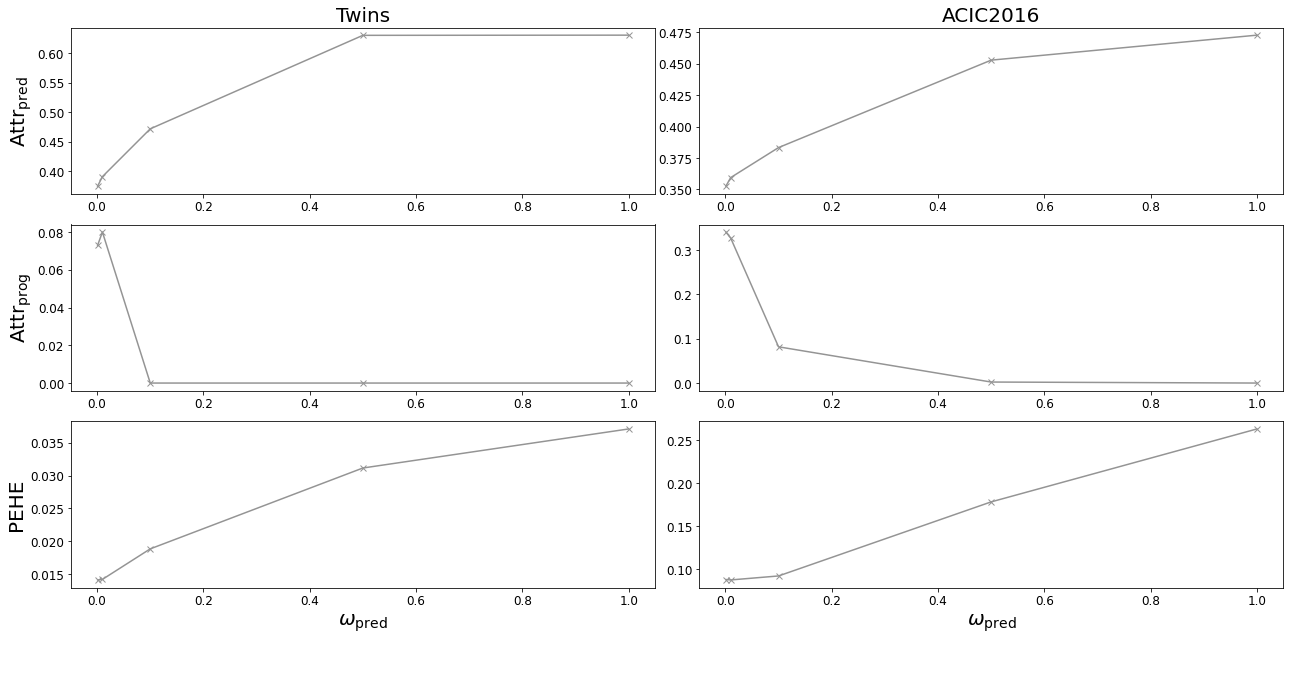

In [ ]:
aggregate_results_and_plot_predictive_sensitivity(datasets_list=datasets_list, 
                                                  num_important_features_list=num_important_features_list, 
                                                  explainer=explainer, 
                                                  metrics_list=metrics_to_plot, 
                                                  synthetic_simulator_type='linear', 
                                                  binary_outcome='False', 
                                                  seeds_list=seeds_list)

In [ ]:
seeds_list = list(range(1, 30))
metrics_to_plot = ['Pred features ACC', 'Prog features ACC',]
aggregate_results_and_plot_nonlinearity_sensitivity(datasets_list=datasets_list, num_important_features_list=num_important_features_list, explainer=explainer, metrics_list=metrics_to_plot, 
                                                  binary_outcome='False', seeds_list=seeds_list)

# Non-linear sensitivity

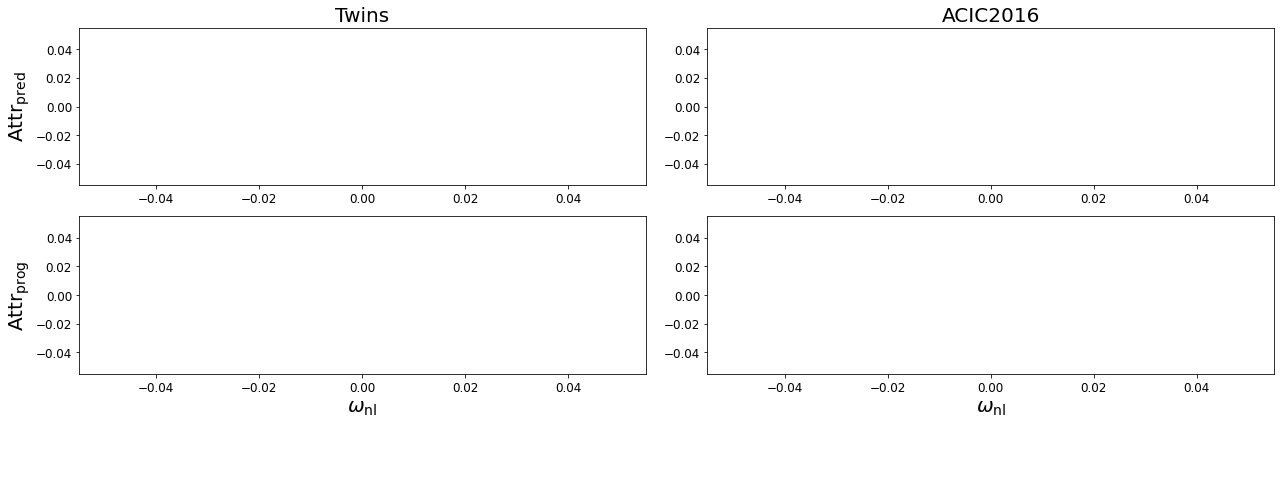

In [ ]:
seeds_list = list(range(1, 2))

metrics_to_plot = ['Pred features ACC', 'Prog features ACC', 'PEHE']
explainer='shapley_value_sampling'
datasets_list = [#'tcga_100',
                 'twins', 
                # 'news_100', 
                 'acic']

num_important_features_list = [#20, 
                               8, 
                              # 20, 
                               10]

metrics_to_plot = ['Pred features ACC', 'Prog features ACC',]
aggregate_results_and_plot_nonlinearity_sensitivity(datasets_list=datasets_list, 
                                                    num_important_features_list=num_important_features_list,
                                                    explainer=explainer, 
                                                    metrics_list=metrics_to_plot, 
                                                    binary_outcome='False', 
                                                    seeds_list=seeds_list)

# Propensity sensitivity

In [ ]:
propensity_type_list = ['pred', 'prog', 'irrelevant_var']
metrics_to_plot = ['Pred features ACC', 'PEHE']
dataset = 'news_100'
num_important_features = 20
seeds_list = list(range(1, 30))
simulation = 'linear'
train_ratio = 0.8

In [ ]:
aggregate_results_and_plot_propensity_sensitivity(
    dataset=dataset,
    num_important_features=num_important_features,
    propensity_type_list=propensity_type_list,
    explainer=explainer,
    metrics_list=metrics_to_plot,
    binary_outcome='False',
    simulation=simulation,
    train_ratio=train_ratio,
    seeds_list=seeds_list
)

FileNotFoundError: ignored

In [ ]:
propensity_type_list = ['pred', 'prog', 'irrelevant_var']
metrics_to_plot = ['Pred features ACC', 'PEHE']
dataset = 'news_100'
num_important_features = 20
seeds_list = list(range(1, 30))
simulation = 'linear'
train_ratio = 0.8

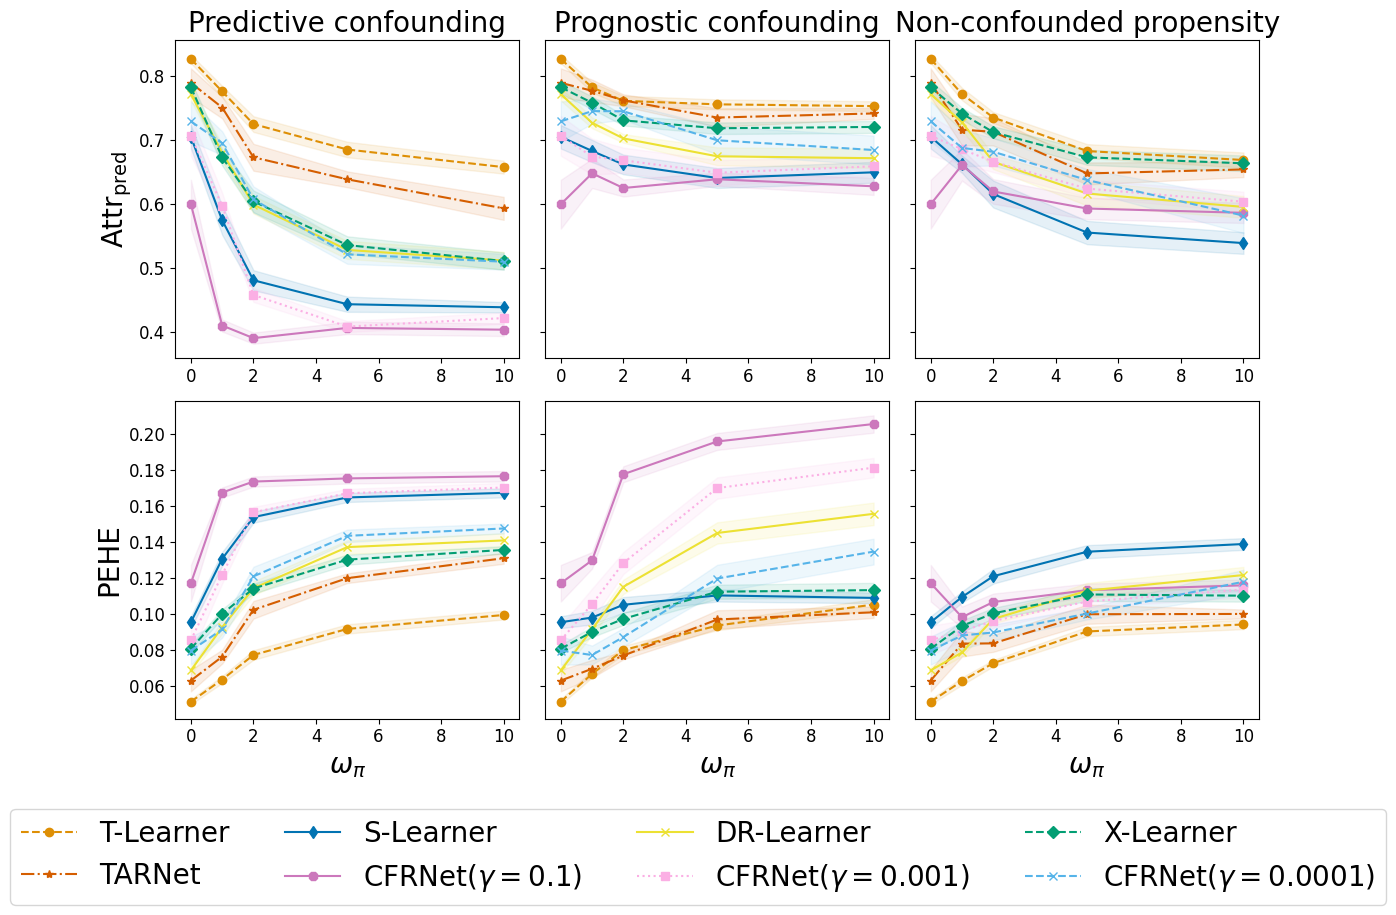

In [ ]:
aggregate_results_and_plot_propensity_sensitivity(
    dataset=dataset,
    num_important_features=num_important_features,
    propensity_type_list=propensity_type_list,
    explainer=explainer,
    metrics_list=metrics_to_plot,
    binary_outcome='False',
    simulation=simulation,
    train_ratio=train_ratio,
    seeds_list=seeds_list
)